#### In this notebook, dimensionality of features is reduced using simple PCA and GPR models are trained on it or directly on feature space to predict energies.

#### Import some required libraries

In [10]:

## Standard libraries
import numpy as np
import pandas as pd
import os
import pickle

## For some analysis
import MDAnalysis as mda
from MDAnalysis.analysis import distances

## For plotting
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec

## For visualization
import nglview as nv

## For some data pre-processing
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA, KernelPCA

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score


#### Global matplot font settings

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

#### Read scalers, train and test data.

#### read scalers

In [3]:
# Save the scaler to a file
with open('./data/x_minmax_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
with open('./data/y_minmax_scaler.pkl', 'rb') as f:
    y_scaler = pickle.load(f)

#### read x and y

In [18]:

# Save features to memory
pca_train_test_file = './data/x_features_y_labels.npy'
with open(pca_train_test_file, 'rb') as f:
    data = pickle.load(f)
        
X_train = data['pca_X_train']
X_test_direct = data['X_train']
X_test = data['pca_X_test']
X_test_direct = data['X_test']
y_train = data['y_train']
y_test = data['y_test']



#### Train GPR to predict PBE energies given the location of structure in PC/direct feature space

In [25]:

#### Create a Gaussian process regression model
# Define the kernel
kernel = RBF(1, (1e-15, 1e15)) # set space for parameter optimization with maximum likelihood equation
noise_levels=0.05 # set some noise to prevent overfitting
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=noise_levels)


# Set number of dimensions of PC to use as features
ndim=100 # GPR gets expensive with dimensions but it is okay for small num of samples. PC may be better. Also, because PC removes linear correlations.

gp_model.fit(X_train.values[:,:ndim], y_train)

# Step 5: Evaluate the model
gpr_train_y_pred_mean, gpr_train_y_pred_sd = gp_model.predict(X_train.values[:,:ndim], return_std=True)
gpr_test_y_pred_mean, gpr_test_y_pred_sd = gp_model.predict(X_test.values[:,:ndim], return_std=True)

print(f"GPR MSE: Train:{mean_squared_error(y_train, gpr_train_y_pred_mean)}, Test:{mean_squared_error(y_test, gpr_test_y_pred_mean)}")
train_r2=r2_score(y_train, gpr_train_y_pred_mean)
test_r2=r2_score(y_test, gpr_test_y_pred_mean)
print(f"GPR R2: Train:{train_r2}, Test:{test_r2}")


GPR MSE: Train:0.01965193433867373, Test:0.02829466094594204
GPR R2: Train:0.7558931424559435, Test:0.6645187175231166


#### Visualize the results

#### Parity plot of ground truth and predictions in train and test 

Text(0, 0.5, 'Predicted (eV)')

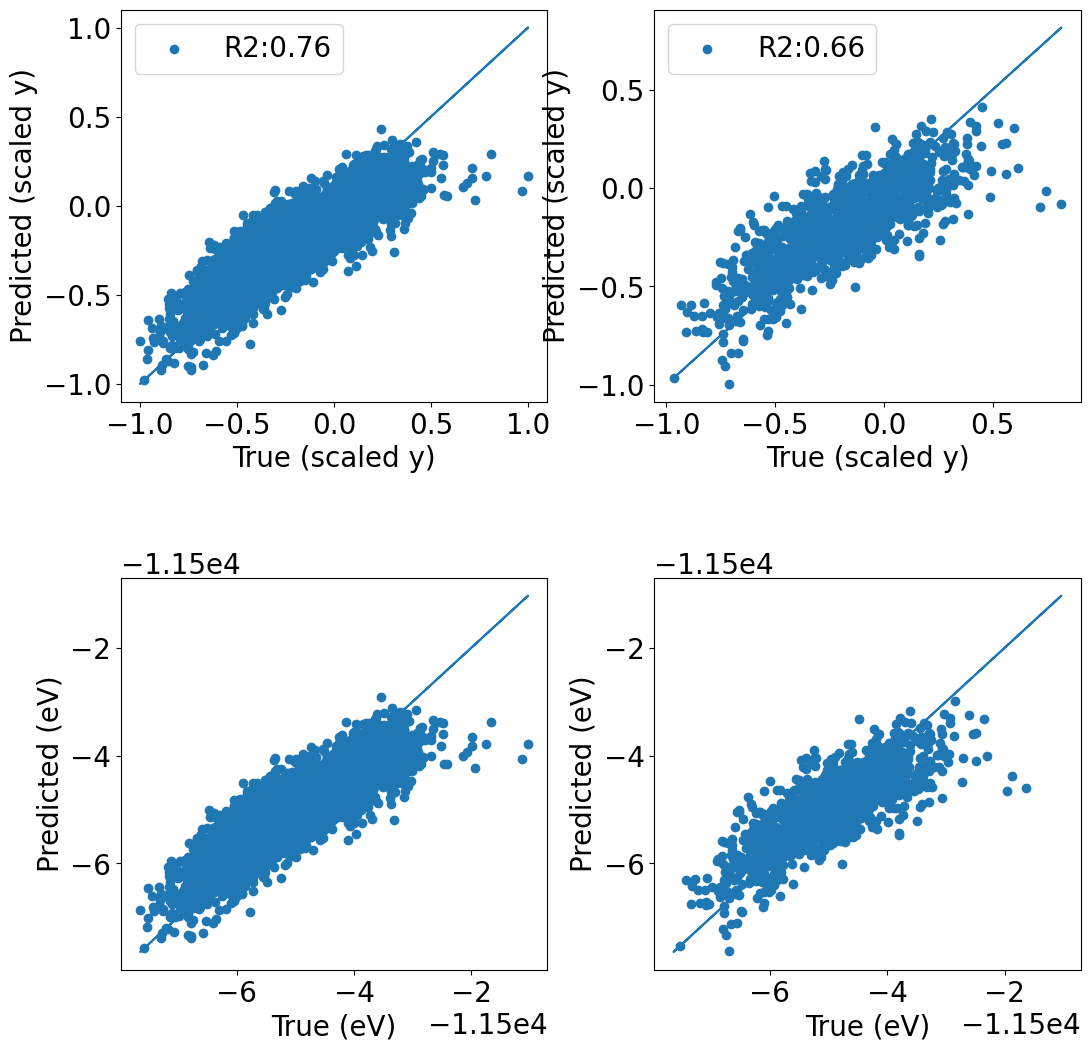

In [26]:
# Set the figure size
fig = plt.figure(figsize=(12, 12))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.45)

nrows=2
ncols=2

# Create a 3x3 grid
grid = GridSpec(nrows, ncols)

ax = plt.subplot(grid[0,0])

ax.scatter(y_train, gpr_train_y_pred_mean, label=f'R2:{np.round(train_r2,2)}')
ax.plot(y_train, y_train)

ax.set_xlabel('True (scaled y)')
ax.set_ylabel('Predicted (scaled y)')
ax.legend()

ax = plt.subplot(grid[0,1])

ax.scatter(y_test, gpr_test_y_pred_mean,label=f'R2:{np.round(test_r2,2)}')
ax.plot(y_test, y_test)

ax.set_xlabel('True (scaled y)')
ax.set_ylabel('Predicted (scaled y)')
ax.legend()



ax = plt.subplot(grid[1,0])

ax.scatter(y_scaler.inverse_transform(y_train.values.reshape(-1,1)), 
           y_scaler.inverse_transform(gpr_train_y_pred_mean.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(y_train.values.reshape(-1,1)), 
        y_scaler.inverse_transform(y_train.values.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')

ax = plt.subplot(grid[1,1])

ax.scatter(y_scaler.inverse_transform(y_test.values.reshape(-1,1)), 
           y_scaler.inverse_transform(gpr_test_y_pred_mean.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(y_train.values.reshape(-1,1)), 
        y_scaler.inverse_transform(y_train.values.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')




#### true values and predicted values against each dimension [scaled values; can be inverted easily]

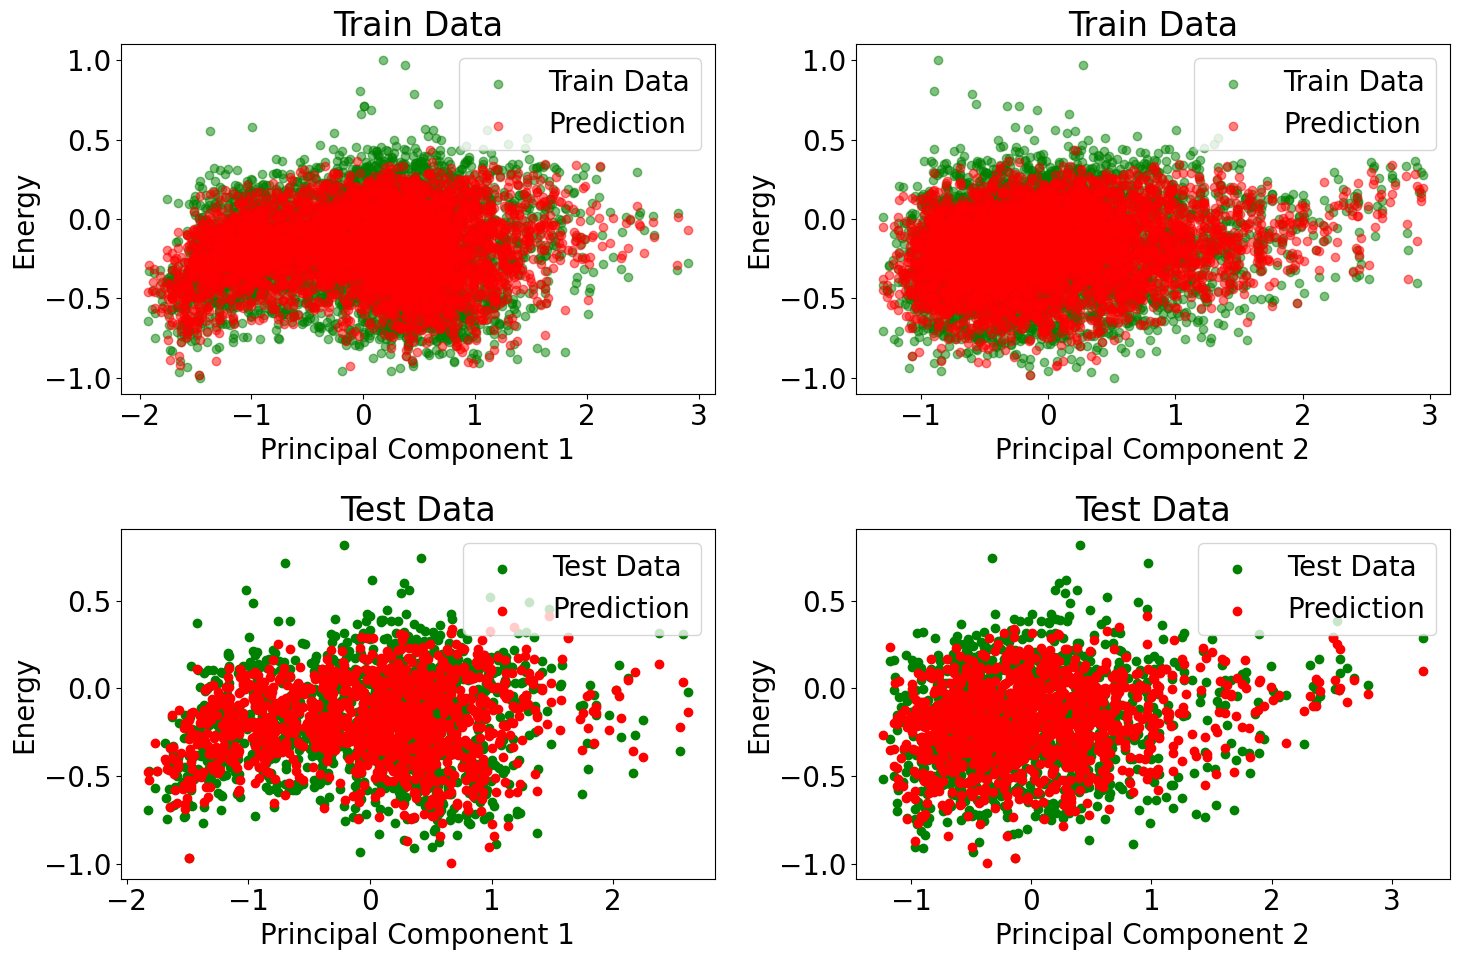

In [27]:

# Plot y values against each principal component for both train and test data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(2):
    # Train data
    axs[0, i].scatter(X_train.values[:, i], y_train, color='green', label='Train Data', alpha=0.5)
    axs[0, i].scatter(X_train.values[:, i], gpr_train_y_pred_mean, color='red', label='Prediction', alpha=0.5)
    
    axs[0, i].set_xlabel(f'Principal Component {i+1}')
    axs[0, i].set_ylabel('Energy')
    axs[0, i].set_title('Train Data')
    
    axs[0, i].legend()

    # Test data
    axs[1, i].scatter(X_test.values[:, i], y_test, color='green', label='Test Data')
    axs[1, i].scatter(X_test.values[:, i], gpr_test_y_pred_mean, color='red', label='Prediction')
    
    axs[1, i].set_xlabel(f'Principal Component {i+1}')
    axs[1, i].set_ylabel('Energy')
    axs[1, i].set_title('Test Data')
    
    axs[1, i].legend()

plt.tight_layout()
plt.show()

#### true values and predicted values against two dimensions at a time [scaled values; can be inverted easily]

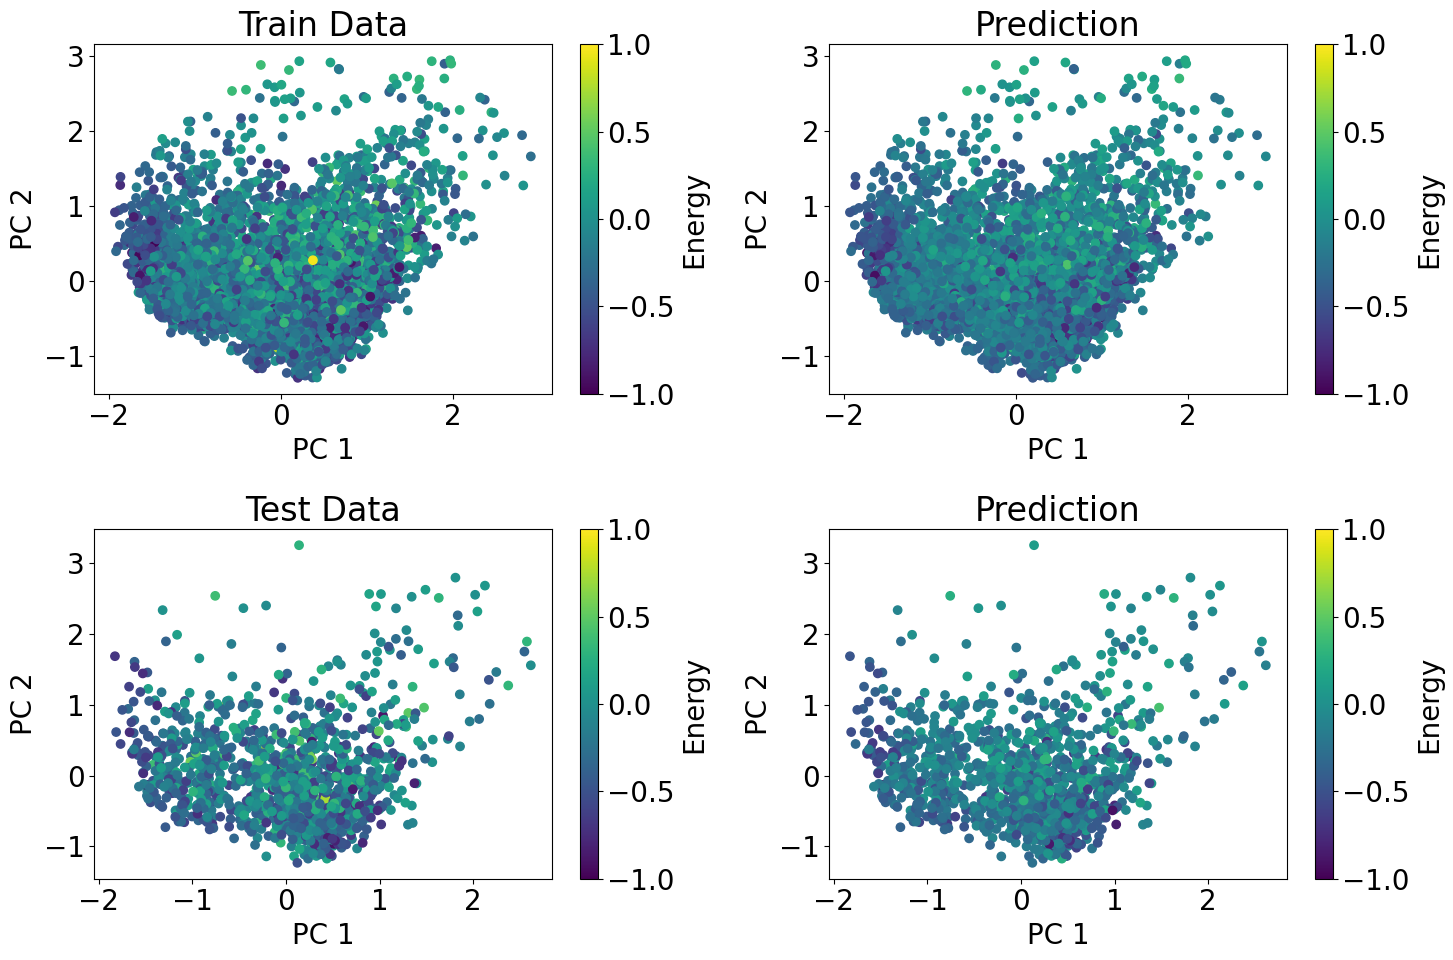

In [28]:

def plot_scatter_with_color(ax, x1, x2, y, title, vmin, vmax, select_pc1, select_pc2):
    scatter = ax.scatter(x1, x2, c=y, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_xlabel('PC '+str(select_pc1+1))
    ax.set_ylabel('PC '+str(select_pc2+1))
    ax.set_title(title)
    #ax.legend()
    plt.colorbar(scatter, ax=ax, label='Energy')

# Create subplots for train and test data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))


select_pc1 = 0
select_pc2 = 1

# Plot train data
plot_scatter_with_color(axs[0, 0], X_train.values[:, select_pc1], X_train.values[:, select_pc2], 
                        y_train, 'Train Data', y_train.min(), y_train.max(), select_pc1, select_pc2)
plot_scatter_with_color(axs[0, 1], X_train.values[:, select_pc1], X_train.values[:, select_pc2], 
                        gpr_train_y_pred_mean, 'Prediction', y_train.min(), 
                        y_train.max(), select_pc1, select_pc2)




# Plot test data
plot_scatter_with_color(axs[1, 0], X_test.values[:, select_pc1], X_test.values[:, select_pc2], 
                        y_test, 'Test Data', 
                        y_train.min(), y_train.max(), select_pc1, select_pc2)
plot_scatter_with_color(axs[1, 1], X_test.values[:, select_pc1], X_test.values[:, select_pc2], 
                        gpr_test_y_pred_mean, 'Prediction',
                        y_train.min(), y_train.max(), select_pc1, select_pc2)


    
plt.tight_layout()
plt.show()
